In [1]:
#import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pyarrow as pa
import seaborn as sns
from datetime import timedelta, datetime

dir = Path(r"S:\Fackler_OSS_364376\data\IRB-364376-v1-230215")

In [2]:
fp = dir.joinpath('EHR', 'd_flo_measures.csv.gz')
dict = pd.read_csv(fp, compression="gzip")

names = ["State Behavioral Scale",
"-3 Unresponsive", 
"-2 Responsive to noxious stimuli", 
"-1 Responsive to gentle touch or voice",
"0 Awake and Able to calm",
"+1 Restless and difficult to calm",
"+2 Agitated",
"State Behavioral Scale (SBS)"]

# note: flowsheet record flow_meas_id as meas_id
# note: SBS score values are only stored in these fields

fmid = [304080016, 304080017, 304080018, 304080019, 304080020, 304080021]


In [11]:
# connect with feather file
fp = dir.joinpath('EHR', 'ptsd_record.csv.gz')

ptsd_record = pd.read_csv(fp, compression="gzip")

# load flow table of all patient EHR records
fp = dir.joinpath('EHR', 'flowsheet.csv.gz')
data = pd.read_csv(fp, compression="gzip")
data = data.drop(columns = ['meas_comment', 'meas_template_id'])
# Note: pandas took 50 seconds to load the table. Consider porting to PySpark RDD

sbs = data[data['meas_id'].isin(fmid)]
# print(sbs.shape)
# 25878 entries

# calculate sbs score from offset
sbs['SBS'] = sbs['meas_id'] - 304080019
sbs = sbs.drop(columns=['meas_value', 'meas_id'])
sbs['recorded_time'] = pd.to_datetime(sbs['recorded_time'], format='%Y-%m-%d %H:%M:%S')
sbs_indiv = sbs.groupby('pat_enc_csn_sid')

# load pre-selected patients from patient_inclexcl.ipynb
patients = np.load('./DONOTPUSH/patients.npy', allow_pickle=True)

c:\Program Files\miniconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Segment pstd and SBS data for ML training

Select Relevant vitals.
For now:
- drop data from Medibus (ventilator system)
- Keep dts, HR, SPO2, RR, 
- TODO: add BP

In [14]:
fp_hl7m = dir.joinpath('ptsd-phi', 'vitals-hl7m', "003", '1000000003-2016-07-07-0.0166667-1-HL7M.feather')
fp_tsdb = dir.joinpath('ptsd-phi', 'vitals-tsdb', "106", '1000002106-2019-01-22-1-TSDB.feather')
fp_gevital = dir.joinpath('ptsd-phi', 'vitals-sb', "672", '1000002672-2020-10-01-1-GEVITAL.feather')
fp_medibus = dir.joinpath('ptsd-phi', 'vitals-sb', "672", '1000002672-2020-10-01-1-MEDIBUSVITAL.feather')

hl7m_order = ['dts', 'HR', 'RR', 'SPO2-%']
tsdb_order = ['dts', 'HR', 'awRR_3495', 'SpO2_7874']
ge_order = ['dts','PARM_HR', 'PARM_RESP_RATE', 'PARM_SPO2_HR1']
metrics = set(hl7m_order + tsdb_order + ge_order)

In [15]:
# turn off error message on .loc
pd.options.mode.chained_assignment = None  # default='warn'

X = []
y = []
# record patient id for stratification
ids = []

# define column header for devices
hl7m_order = ['dts', 'HR', 'RR', 'SPO2-%']
tsdb_order = ['dts', 'HR', 'awRR_3495', 'SpO2_7874']
ge_order = ['dts','PARM_HR', 'PARM_RESP_RATE', 'PARM_SPO2_HR1']
metrics = set(hl7m_order + tsdb_order + ge_order)

for p in patients:
    files = ptsd_record[ptsd_record['pat_enc_csn_sid'] == p]
    files['start_time'] = pd.to_datetime(files['start_time'], format='%Y-%m-%d %H:%M:%S')
    files['end_time'] = pd.to_datetime(files['end_time'], format='%Y-%m-%d %H:%M:%S')
    files.sort_values('start_time')

    devices = files['device']
    filename = files['filename'] + '.feather'
    startime = files['start_time']

    dfs = []
    size = 0 
    for (d, fn, t0) in zip(devices, filename, startime): 
        # drop 'MEDIBUSVITAL' since it is a ventilator (we dont want ventilated patients)
        if fn.endswith('MEDIBUSVITAL.feather'):
            continue
        # HL7M', 'TSDB', 'GEVITAL'
        if (d.endswith('HL7M') or d.endswith('TSDB')):
            fp_device = 'vitals-' + d.lower()
        else:
            fp_device = 'vitals-sb'
        fp_p = str(p)[-3:] # last 3 digit of pat_enc_csn_sid is the subfolder
        fp = dir.joinpath('ptsd-phi', fp_device, fp_p, fn)
        if (fp == None):
            print(fp, "does not exist")
            continue

        df = pd.read_feather(fp, columns=None, use_threads=True, storage_options=None)
        df = df.filter(metrics)
        # rearrange columns according to device
        if d.endswith('HL7M'):
            df = df.reindex(columns=hl7m_order)
        elif d.endswith('TSDB'):
            df = df.reindex(columns=tsdb_order)
        elif d.endswith('GEVITAL'):
            df = df.reindex(columns=ge_order)

        df.loc[:,'dts'] = pd.to_timedelta(df.loc[:,'dts'], unit='s')
        df.loc[:,'dts'] = df.loc[:,'dts'] + t0
        dfs.append(df)
    patient_multi = pd.concat(dfs, axis=0) 
    patient_multi = patient_multi.sort_values(by=['dts'])

    # add SBS
    sbs_p = sbs_indiv.get_group(p).sort_values('recorded_time')
    sbs_p = sbs_p.drop(columns=['osler_sid', 'pat_enc_csn_sid'])

    # slice into X and y array
    for i in range(len(sbs_p)):
        t1 = sbs_p['recorded_time'].iloc[i]
        t0 = t1 - timedelta(seconds=60*60) # 60 minutes prior

        dat = patient_multi.loc[(patient_multi['dts'] >= t0)
                        & (patient_multi['dts'] <= t1)]
        # drop rows with non-constant time intervals
        t_diff = dat['dts'].diff()
        # force all time interval to be constant
        dat = dat[t_diff == pd.Timedelta(60,unit="S")].reset_index(drop=True)
        # sample to 60
        if (dat.shape[0] > 59 and dat.shape[1] == 4):
            X.append(dat.drop(columns=['dts']).to_numpy())
            y.append(sbs_p.iloc[i,1])
            ids.append(p)

X = np.array(X)
y = np.array(y)
ids = np.array(ids)

In [16]:
# replace missing data with unphysiological value
X = np.nan_to_num(X, nan=-1)

# reshape
X = np.transpose(X, (0, 2, 1))

print(X.shape)
print(y.shape)
print(ids.shape)

np.save('./DONOTPUSH/waveforms_60min.npy',X)
np.save('./DONOTPUSH/sbs_60min.npy',y)
np.save('./DONOTPUSH/ids_60min.npy',ids)

(867, 3, 60)
(867,)
(867,)


(array([  1.,   0.,   6.,   0., 152.,   0., 636.,   0.,  51.,  21.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

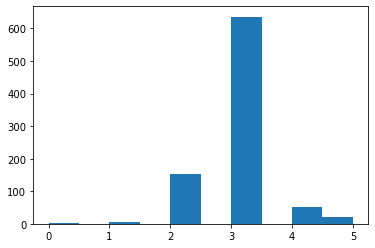

In [18]:
X = np.load('./DONOTPUSH/waveforms_60min.npy')
y = np.load('./DONOTPUSH/sbs_60min.npy')
ids = np.load('./DONOTPUSH/ids_60min.npy')

# shift SBS label: multiclass classifier needs labels to start from 0
y += 3
plt.hist(y)

#### Visualize patient data

RR seems to be mostly missing (padded to -1)
SpO2 mostly constant near 100
HR elevated in oversedated?

In [46]:
(undersed,) = np.where(y == 5)
(oversed,) = np.where(y == 1)

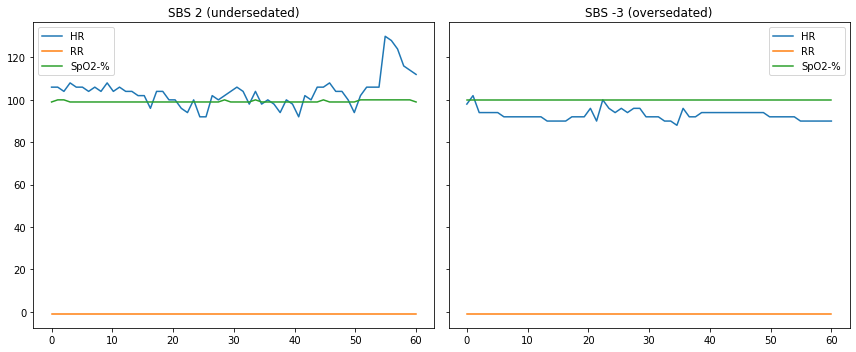

In [56]:
# visualize one
t = np.linspace(0, 60, 60)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

p = undersed[4]
dat = X[p, :, :]
ax1 = axs[0]
ax1.plot(t, dat[0], label='HR')
ax1.plot(t, dat[1], label='RR')
ax1.plot(t, dat[2], label='SpO2-%')
ax1.set_title('SBS 2 (undersedated)')
ax1.legend()

p = oversed[2]
dat = X[p, :, :]
ax2 = axs[1]
ax2.plot(t, dat[0], label='HR')
ax2.plot(t, dat[1], label='RR')
ax2.plot(t, dat[2], label='SpO2-%')
ax2.set_title('SBS -3 (oversedated)')
ax2.legend()

plt.tight_layout()
plt.show()

#### ML pipeline

Idea list: https://github.com/danielgy/Paper-list-on-Imbalanced-Time-series-Classification-with-Deep-Learning

In [17]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

from sktime.datasets import load_basic_motions  # multivariate dataset
from sktime.transformations.panel.rocket import Rocket
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler, SMOTE

(4291, 3, 60)
(1139, 3, 60)


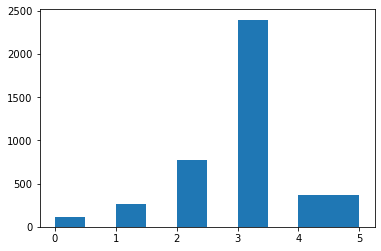

(array([ 24.,   0.,  67.,   0., 210.,   0., 660.,   0., 125.,  53.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

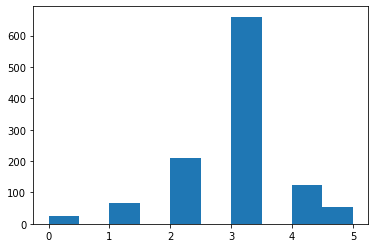

In [176]:
# preserve class ratio in train and test set
# X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# split by patient instead to reduce bias. 
# n_splits for cross validation
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
split = gss.split(X, y, ids)
train_index, test_index = next(split)

X_train = X[train_index,:,:]
y_train = y[train_index]
X_test = X[test_index,:,:]
y_test = y[test_index]

print(X_train.shape)
print(X_test.shape)

# check class distribution of training and test groups
plt.hist(y_train)
plt.show()
plt.hist(y_test)
# visually, they look similar

Normalize data onto 0-1 range for each physiological parameter.
- Another approach is standardization to 0 mean and 1 std, but here we don't expect physiology to fall onto a normal curve
- This is vulnerable to the test distribution being different from the train distribution in terms of minmax. A obvious flaw is that age is strongly correlated to range of heart rate

In [177]:
from numpy import newaxis
minX = np.min(X_train, axis=(0,2)).reshape(3, 1)[newaxis, :, :]
maxX = np.max(X_train, axis=(0,2)).reshape(3, 1)[newaxis, :, :]
X_train = (X_train - minX) / (maxX - minX)

# note the test dataset is standardized to the min/max of the train set
X_test = (X_test - minX) / (maxX - minX)

Addressing class imbalance:
Common strategies for class imbalance are random upsampling and downsampling, as well as synthetic upsampling.
- Random downsampling: remove examples from the most common class. This is not preferred here since we do not have too many data points
- Random upsampling: repeating rare classes
- Synthetic upsampling generates synthetic data using available data distribution. We use [SMOTE](https://arxiv.org/pdf/1106.1813.pdf), a highly-cited algorithm
Importantly, upsampling is only done on the training data

However, the results did not fix classification bias. There is also theoretical work suggesting that for strong classifiers, tuning the threshold is better than SMOTE (https://arxiv.org/abs/2201.08528)

(15288, 3, 30)


(array([2548.,    0., 2548.,    0., 2548.,    0., 2548.,    0., 2548.,
        2548.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

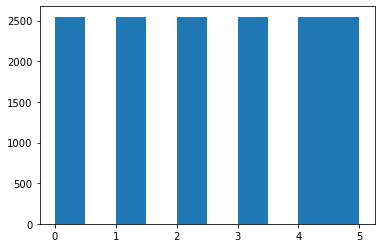

In [129]:
# randomly upsample rare classes
# sampler = RandomOverSampler(random_state=42)

# synthetic upsampling using SMOTE
# sampler = SMOTE()

# samples = X_train.shape[0]
# dims = X_train.shape[1]
# times = X_train.shape[2]

# X_lin = X_train.reshape(samples,-1)
# X_oversample, y_train = sampler.fit_resample(X_lin, y_train)
# X_train = X_oversample.reshape((X_oversample.shape[0], dims, times))

# print(X_train.shape)
# plt.hist(y_train)

In [178]:
rocket = Rocket()
rocket.fit(X_train)
# transform patient waveform into features using ROCKET
X_train_transform = rocket.transform(X_train)
X_test_transform = rocket.transform(X_test)

XGBoost:
- [Workflow tutorial](https://xgboost.readthedocs.io/en/stable/python/python_intro.html)
- [Hyperparameter list](https://xgboost.readthedocs.io/en/stable/parameter.html)

- [Hyperparameter tuning tutorial (Section 2)](https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663)

An alternative to upsampling is to weigh samples by class rarity

In [181]:
# use xgboost classifier
dtrain = xgb.DMatrix(X_train_transform, label=y_train)
dtest = xgb.DMatrix(X_test_transform, label=y_test)
evallist = [(dtrain, 'train'), (dtest, 'eval')]
evalset = [(X_train_transform, y_train), (X_test_transform, y_test)]

param = {'n_estimators': 15,
         'max_depth': 10, 
         'learning_rate': 0.2,          # try 0.01, 0.1, and 1 first
         'colsample_bytree': 1,
         'subsample': 0.9,
         'gamma': 10,
         'objective': 'multi:softmax', 
         'num_class': 6,
         'eval_metric': 'auc'}

# https://towardsdatascience.com/how-to-handle-multiclass-imbalanced-data-say-no-to-smote-e9a7f393c310
class_weight = class_weight.compute_class_weight(class_weight ='balanced', classes=np.unique(y_train), y=y_train)

# double * to unpack param
model = xgb.XGBClassifier(**param)
model.fit(X_train_transform, y_train, eval_set=evalset)
# bst = xgb.train(param, dtrain, num_round, evallist)

# observe that as train AUC increase, eval AUC decrease
# this indicates model overfitting (or the data is fundamentally different)
# more model tuning is required

[0]	validation_0-auc:0.83505	validation_1-auc:0.57232
[1]	validation_0-auc:0.87962	validation_1-auc:0.59065
[2]	validation_0-auc:0.89504	validation_1-auc:0.60433
[3]	validation_0-auc:0.91117	validation_1-auc:0.61132
[4]	validation_0-auc:0.91998	validation_1-auc:0.61832
[5]	validation_0-auc:0.92222	validation_1-auc:0.61946
[6]	validation_0-auc:0.92585	validation_1-auc:0.62570
[7]	validation_0-auc:0.92840	validation_1-auc:0.62551
[8]	validation_0-auc:0.93166	validation_1-auc:0.62545
[9]	validation_0-auc:0.93310	validation_1-auc:0.62950
[10]	validation_0-auc:0.93738	validation_1-auc:0.63211
[11]	validation_0-auc:0.93849	validation_1-auc:0.63298
[12]	validation_0-auc:0.94082	validation_1-auc:0.63169
[13]	validation_0-auc:0.94213	validation_1-auc:0.63193
[14]	validation_0-auc:0.94531	validation_1-auc:0.63290


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=10, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=15, n_jobs=0,
              num_class=6, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', random_state=0, ...)

Accuracy: 0.579


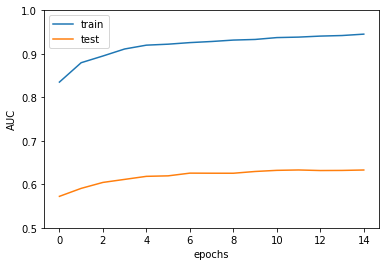

In [184]:
# evaluate performance
yhat = model.predict(X_test_transform)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = model.evals_result()
# we can save this into a list, or plot it

# plot learning curves
plt.plot(results['validation_0']['auc'], label='train')
plt.plot(results['validation_1']['auc'], label='test')
plt.xlabel('epochs')
plt.ylabel('AUC')
# plot from 0 to 1
plt.ylim(0.5,1)
# show the legend
plt.legend()
# show the plot
plt.show()

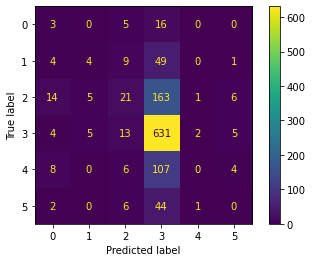

In [185]:
y_class = np.unique(y)
cm = confusion_matrix(y_test, yhat, labels=y_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_class)
disp.plot()